# Case Study (Darwin's Finches: A Full-Blown Statistical Analysis)

Every year for the past 40-plus years, Peter and Rosemary Grant have gone to the Galápagos island of Daphne Major and collected data on Darwin's finches. Using your skills in statistical inference, you will spend this chapter with their data, and witness first hand, through data, evolution in action.

## EDA of beak depths of Darwin's finches

For your first foray into the Darwin finch data, you will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

In the next few problems, you will look at the beak depth of G. scandens on Daphne Major in 1975 and in 2012. To start with, let's plot all of the beak depth measurements in 1975 and 2012 in a bee swarm plot.

The data are stored in a pandas DataFrame called `df` with columns `'year'` and `'beak_depth'`. The units of beak depth are millimeters (mm).

<img src="images/beak-depth.png" alt="" style="width: 400px;"/> <img src="images/beak-length.png" alt="" style="width: 300px;"/>


## Approach

- Graphical and quantitative EDA
- Parameter estimation
- Confidence interval calculation
- Hypothesis testing

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

path = 'data/dc15/'

In [6]:
df = pd.read_csv(path+'finch_beaks.csv', index_col=0)
df.head()

,beak_depth,year
0,8.4,1975
1,8.8,1975
2,8.4,1975
3,8.0,1975
4,7.9,1975


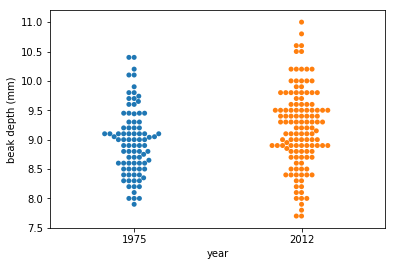

In [9]:
# Create bee swarm plot
_ = sns.swarmplot(x='year', y='beak_depth', data=df)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the `mean` of the 2012 data set might be slightly higher, and it might have a bigger `variance`.

## ECDFs of beak depths

While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA. Plot the ECDFs for the 1975 and 2012 beak depth measurements on the same plot.

For your convenience, the beak depths for the respective years has been stored in the NumPy arrays `bd_1975` and `bd_2012`.

In [14]:
bd_1975 = np.array(df[df['year'] == 1975]['beak_depth'])
bd_2012 = np.array(df[df['year'] == 2012]['beak_depth'])

In [15]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

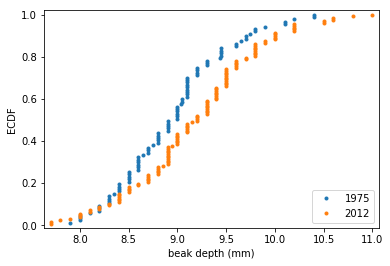

In [16]:
# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

The differences are much clearer in the ECDF. The `mean` is larger in the 2012 data, and the `variance` does appear larger as well.

## Parameter estimates of beak depths

Estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval.

- Compute the difference of the sample means.
- Take 10,000 bootstrap replicates of the mean for the 1975 beak depths using your `draw_bs_reps()` function. Also get 10,000 bootstrap replicates of the mean for the 2012 beak depths.
- Subtract the 1975 replicates from the 2012 replicates to get bootstrap replicates of the difference of means.
- Use the replicates to compute the 95% confidence interval.

In [17]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [18]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.05817655 0.38897004] mm


## Hypothesis test: Are beaks deeper in 2012?

Your plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

Be careful! The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal. To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.